In [56]:
from processing.BikeDataImporter import BikeDataImporter
from processing.DataPreparing import DataPreparing

import lightgbm as lgb
import pandas as pd
import numpy as np
import holidays
from suntime import Sun, SunTimeException
from datetime import datetime
import optuna
from sklearn.metrics import mean_pinball_loss
from sklearn.model_selection import TimeSeriesSplit
from sktime.split import ExpandingSlidingWindowSplitter
from sklearn.metrics import d2_pinball_score
from statsmodels.tsa.seasonal import MSTL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib import pyplot as plt
import os
from pathlib import Path
from sklearn.linear_model import QuantileRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from statsforecast import StatsForecast
from statsforecast.models import MSTL
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib as mpl
import plotly.graph_objects as go

from processing.DataPreparing import DataPreparing
from processing.forecasting_and_saving import forecasting_and_saving

from models.LightGBM_Model import LightGBM_Model
from models.MSTL_Model import MSTL_Model
from models.LinearQuantileRegression_Model import LinearQuantileRegression_Model
from models.GradientBoostingRegressor_Model import GradientBoostingRegressor_Model
from models.Baseline_Model import Baseline_Model

import optuna
from sklearn.metrics import mean_pinball_loss
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import d2_pinball_score
from statsmodels.tsa.seasonal import MSTL
from matplotlib import pyplot as plt
import os
from pathlib import Path
from sklearn.linear_model import QuantileRegressor
from sklearn.impute import SimpleImputer
from sklearn.ensemble import GradientBoostingRegressor
from statsforecast import StatsForecast
from statsforecast.models import MSTL
from sklearn.preprocessing import LabelEncoder
from typing import Tuple, Dict, List
import seaborn as sns
import pandas as pd

In [57]:
plt.style.use("stylesheet.mplstyle")

In [58]:
data_preparer = DataPreparing()

# Data Importing for bike data
data_bike = data_preparer.get_bike_and_weather_data()
todays_date = pd.Timestamp.now(tz=data_bike.index.tz) - pd.Timedelta(days=1)
bike_past = data_bike.loc[data_bike.index < todays_date]
# bike_past = bike_past.loc[bike_past.index <= '2024-11-01'] # Cut off the data at the end of the year 2024 because this will be tested !!!
bike_past.loc[:,'bike_count'] = bike_past['bike_count'].fillna(int(data_bike['bike_count'].mean())) # Missing value for 03.01.2025
bike_future = data_bike.loc[data_bike.index >= todays_date]

# Data Importing for the energy data
data_energy = data_preparer.get_energy_and_weather_data() # Still have to change the weather data from karslruhe to germany
reversed_nan = data_energy['consumption'][::-1].notna() # Look for the index where the nan values start to separate into past and future values
first_nan_index = reversed_nan.idxmax()
energy_past = data_energy.loc[data_energy.index <= first_nan_index]
energy_past = energy_past.loc[energy_past.index > '2022-01-01']
# energy_past = energy_past.loc[energy_past.index <= '2024-11-01'] # Cut off the data at the end of the year 2024 because this will be tested !!!
energy_future = data_energy.loc[data_energy.index > first_nan_index]


100%|██████████| 213/213 [00:17<00:00, 12.29it/s]


In [60]:
data_preparer = DataPreparing()

energy_past = data_preparer.create_features_iterative(energy_past, 'consumption')

In [61]:
energy_past.columns

Index(['consumption', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'rain', 'snowfall',
       'snow_depth', 'pressure_msl', 'surface_pressure', 'cloud_cover',
       'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'et0_fao_evapotranspiration', 'vapour_pressure_deficit',
       'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m',
       'wind_direction_100m', 'wind_gusts_10m', 'soil_temperature_0_to_7cm',
       'soil_moisture_0_to_7cm', 'wet_bulb_temperature_2m',
       'sunshine_duration', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'direct_normal_irradiance',
       'global_tilted_irradiance', 'terrestrial_radiation',
       'shortwave_radiation_instant', 'direct_radiation_instant',
       'diffuse_radiation_instant', 'direct_normal_irradiance_instant',
       'global_tilted_irradiance_instant', 'terrestrial_radiation_instant',
       'month', 'day', 'quarter', 'weekday', 'y

<Axes: >

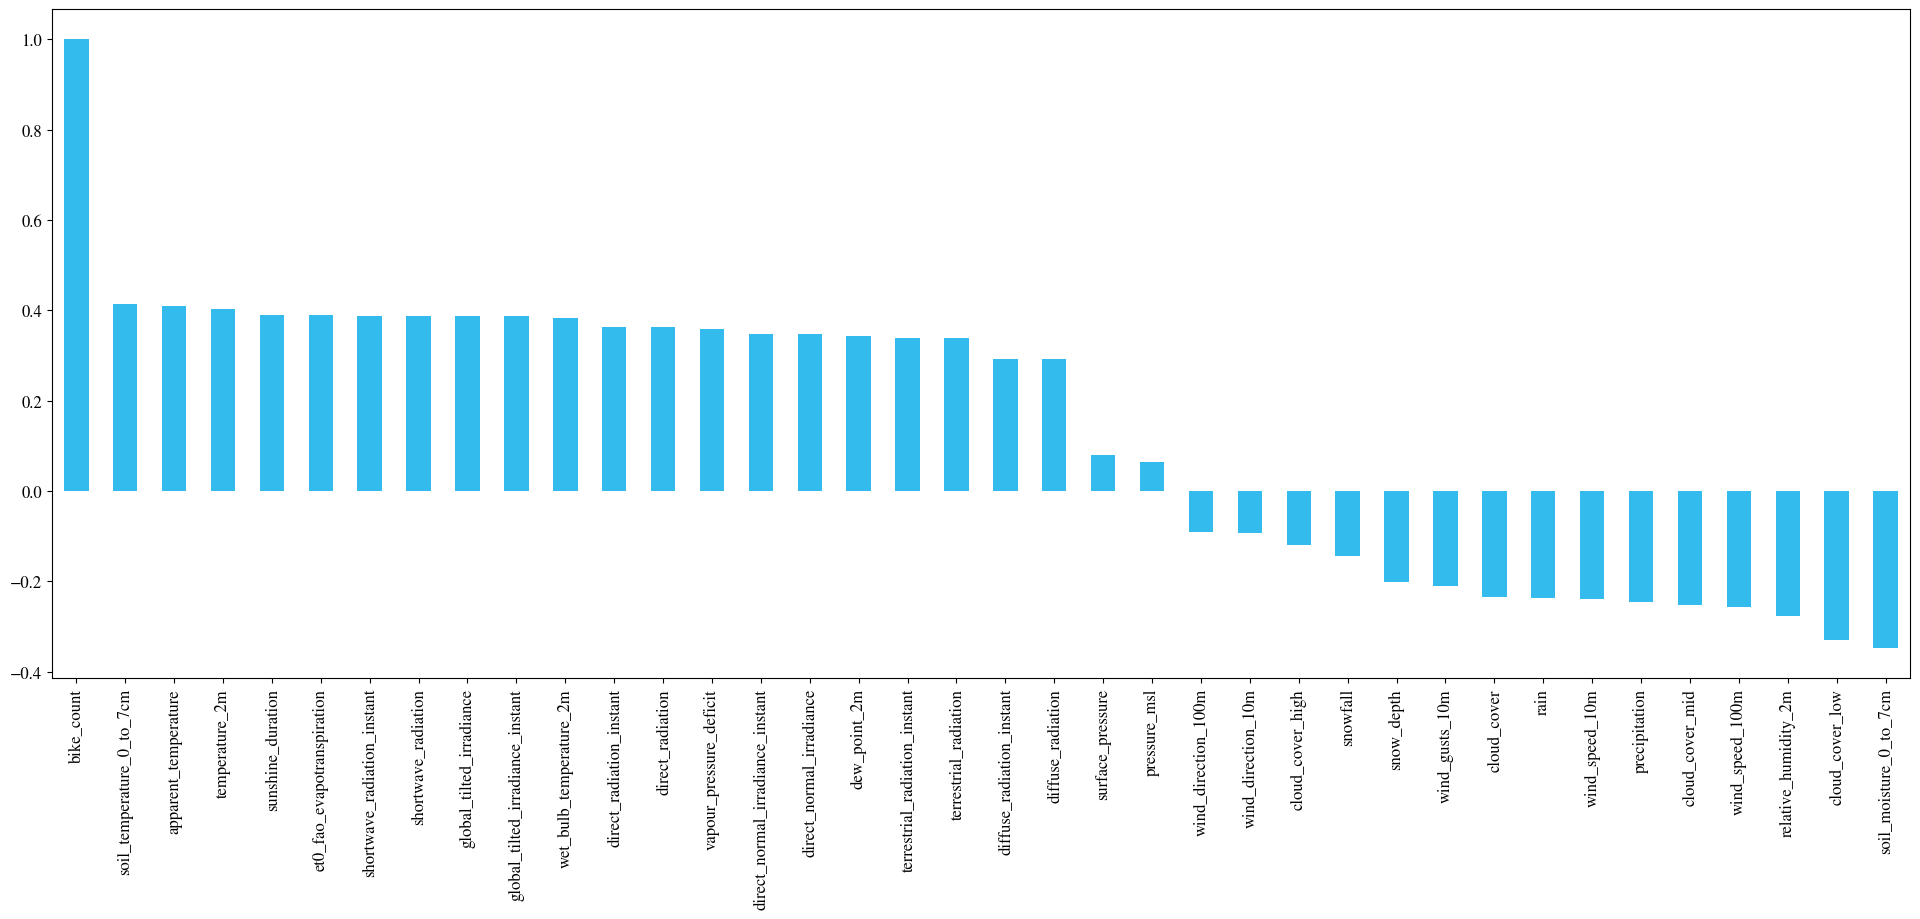

In [5]:
# Plot the correlation of the features with the target bike_count
correlation = bike_past.corr()
correlation['bike_count'].sort_values(ascending=False).plot(kind='bar', figsize=(20, 10))

<Axes: >

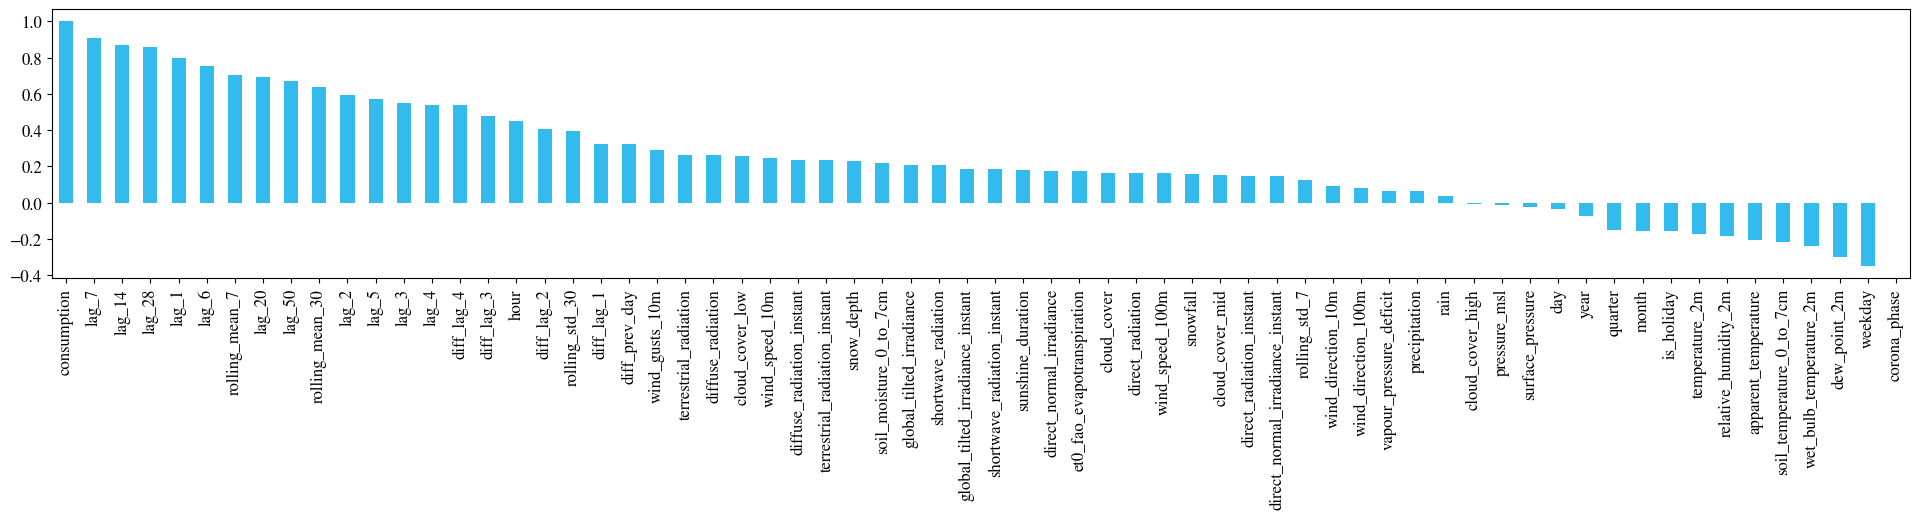

In [65]:
# Plot the correlation of the features with the target bike_count
correlation = energy_past.corr()
correlation['consumption'].sort_values(ascending=False).plot(kind='bar', figsize=(20, 6))

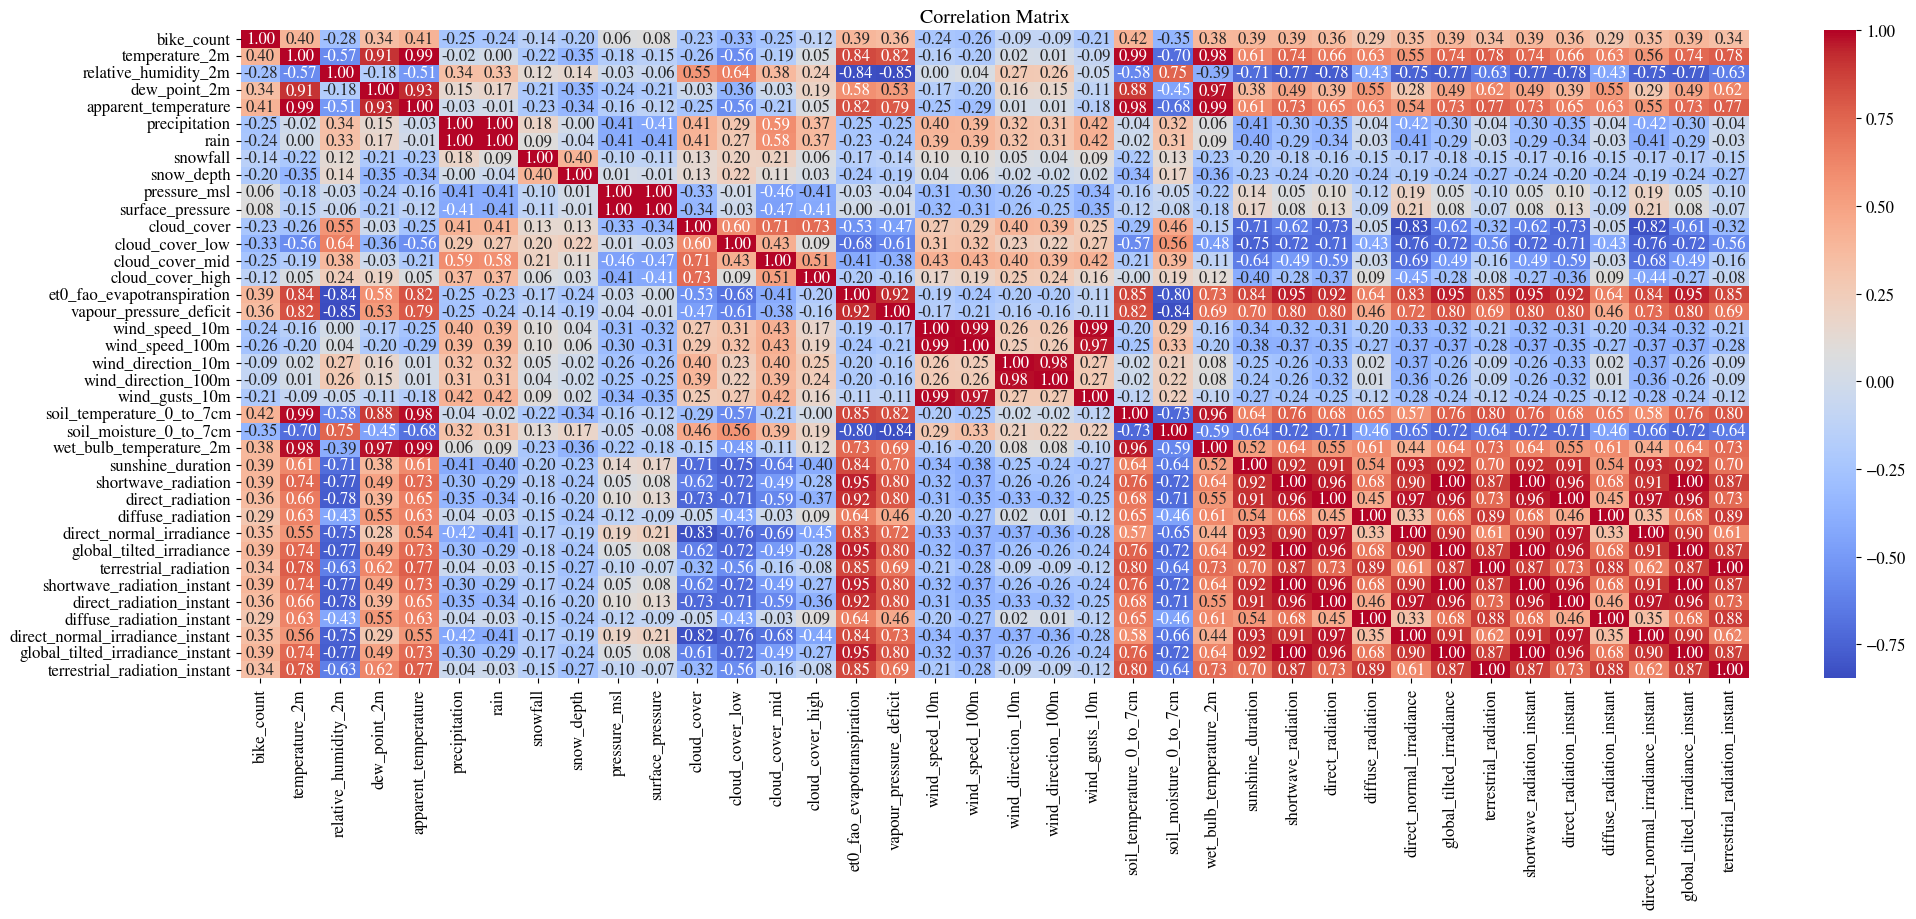

In [7]:
# Plot the peasron correlation matrix
correlation = bike_past.corr()

# Select from the data just some specific columns
# data_selected = bike_past[
#     [
#         "bike_count",
#         "temperature_2m",
#         "precipitation",
#         "rain",
#         "snowfall",
#         "snow_depth",
#         "month",
#         "quarter",
#         "weekday",
#         "lag_5",
#         "lag_6",
#         "lag_7",
#         "lag_8",
#         "lag_9",
#         "is_holiday",
#         "corona_phase",
#     ]
# ]
plt.figure(figsize=(20, 10))
correlation = bike_past.corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()


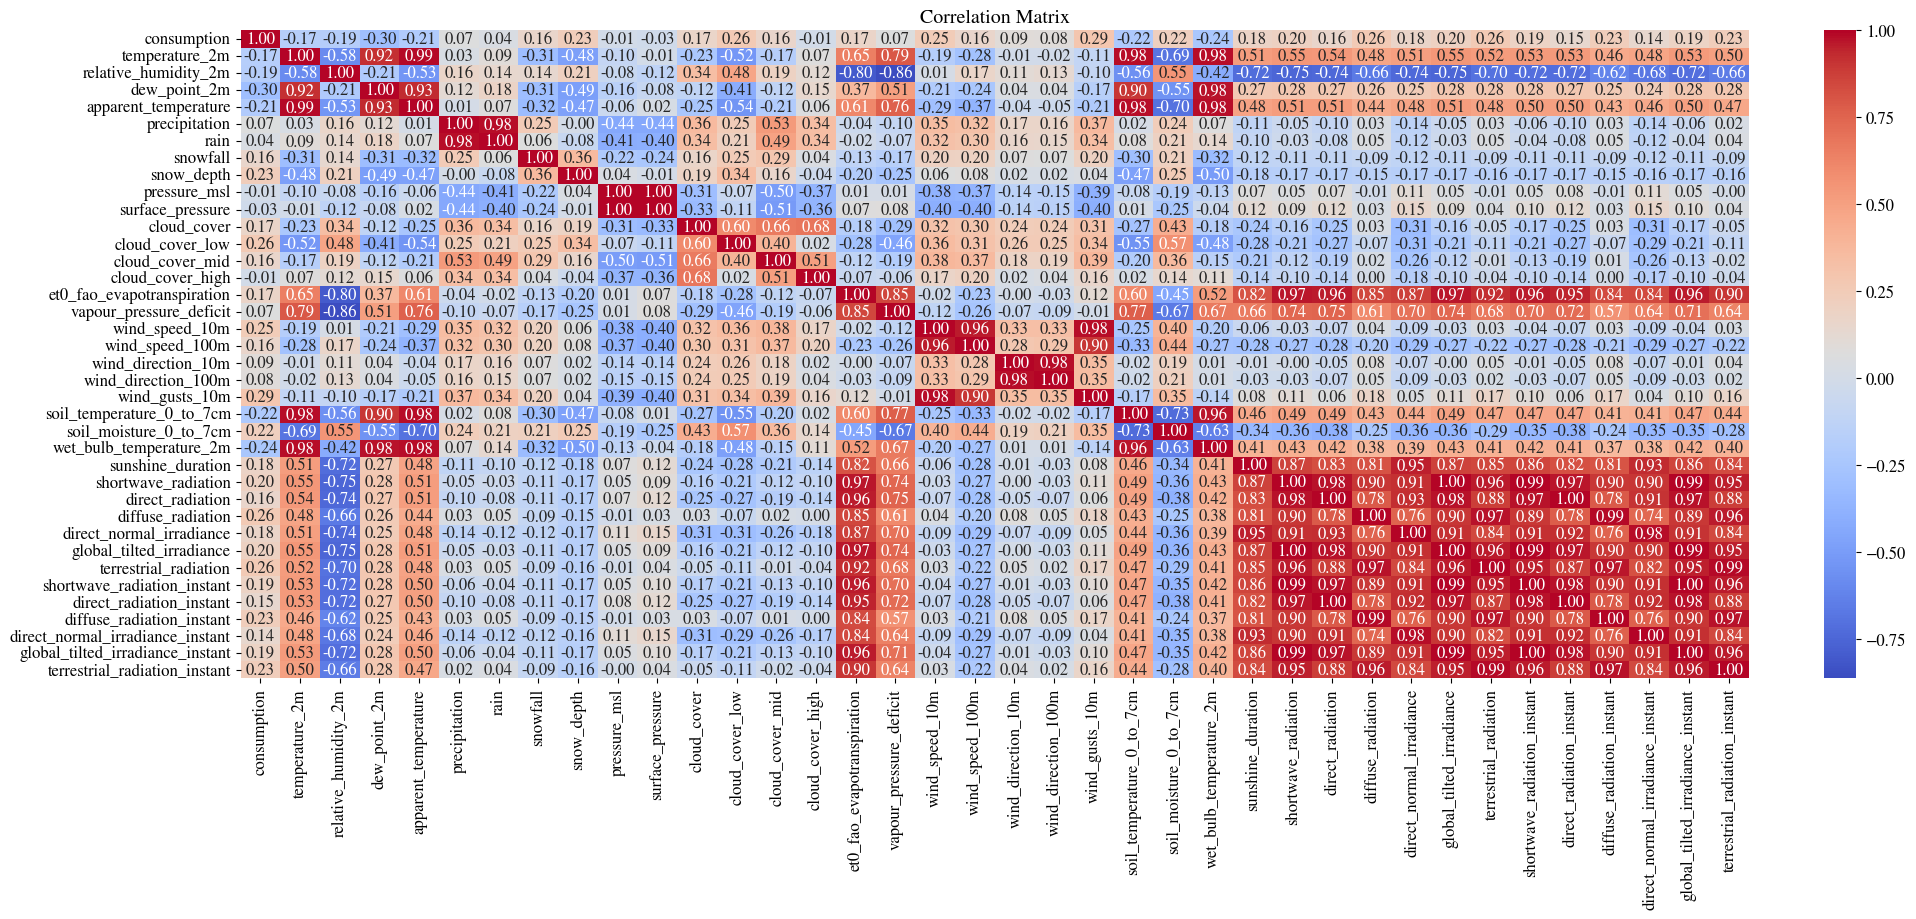

In [8]:
plt.figure(figsize=(20, 10))
correlation = energy_past.corr()
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

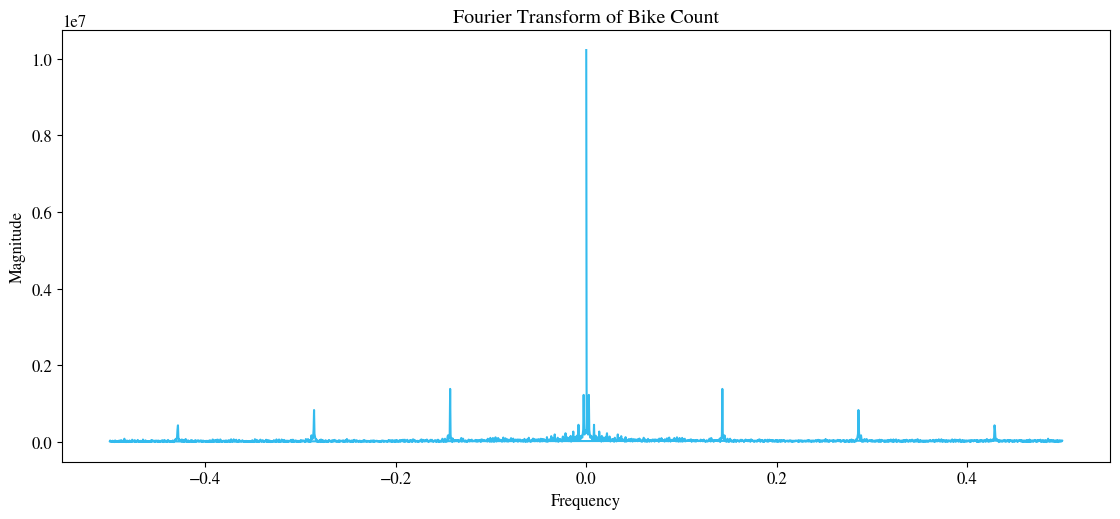

In [9]:
from scipy.fft import fft
import numpy as np

bike_count_fft = fft(bike_past["bike_count"].values)
freqs = np.fft.fftfreq(len(bike_count_fft))
magnitudes = np.abs(bike_count_fft)

plt.figure(figsize=(12, 6))
plt.plot(freqs, magnitudes)
plt.title("Fourier Transform of Bike Count")
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.show()

In [10]:
# Example: Identify dominant frequencies
from scipy.fft import fft, fftfreq

n = len(bike_past["bike_count"])  # Number of data points
freq = fftfreq(n)  # Frequency
fft_values = fft(bike_past["bike_count"])  # Fourier transform values
magnitudes = np.abs(fft_values)

# Sort and find top frequencies
sorted_indices = np.argsort(magnitudes)[::-1]
dominant_freqs = freq[sorted_indices[:3]]  # Top 3 frequencies
periods = 1 / dominant_freqs  # Convert frequencies to periods
print("Dominant Frequencies:", dominant_freqs)
print("Corresponding Periods (in days):", periods)

Dominant Frequencies: [ 0.          0.14279238 -0.14279238]
Corresponding Periods (in days): [       inf  7.0031746 -7.0031746]


C:\Users\simon\AppData\Local\Temp\ipykernel_5308\1461776555.py:12: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / dominant_freqs  # Convert frequencies to periods


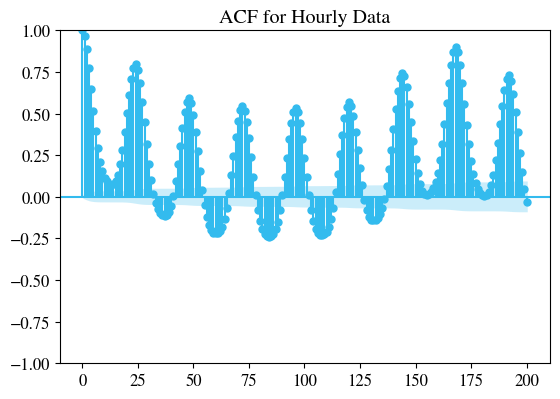

In [11]:
from statsmodels.graphics.tsaplots import plot_acf

# Assuming `data` is your hourly DataFrame
plot_acf(energy_past.dropna(subset=['consumption'])['consumption'], lags=200)  # Plot for up to 200 lags (adjust as needed)
plt.title("ACF for Hourly Data")
plt.show()

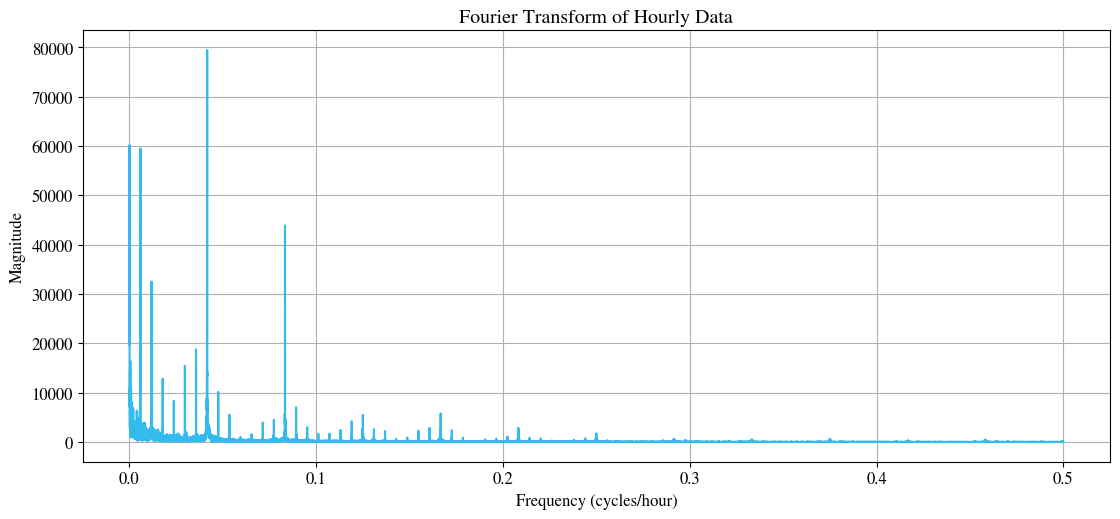

In [12]:
from scipy.fft import fft, fftfreq
import numpy as np

# Assuming `data` is your hourly time series
n = len(energy_past.dropna(subset=['consumption'])['consumption'])  # Number of data points
sampling_rate = 1  # One observation per hour

fft_values = fft(energy_past.dropna(subset=['consumption'])['consumption'])  # Compute Fourier Transform
frequencies = fftfreq(n, d=1/sampling_rate)  # Frequencies (cycles/hour)
magnitudes = np.abs(fft_values)  # Magnitude of FFT

# Filter positive frequencies
positive_freqs = frequencies[frequencies > 0]
positive_magnitudes = magnitudes[frequencies > 0]

# Plot the Fourier Transform
plt.figure(figsize=(12, 6))
plt.plot(positive_freqs, positive_magnitudes)
plt.title("Fourier Transform of Hourly Data")
plt.xlabel("Frequency (cycles/hour)")
plt.ylabel("Magnitude")
plt.grid()
plt.show()

In [13]:
# Example: Identify dominant frequencies
from scipy.fft import fft, fftfreq

n = len(energy_past.dropna(subset=['consumption'])['consumption'])  # Number of data points
freq = fftfreq(n)  # Frequency
fft_values = fft(energy_past.dropna(subset=['consumption'])['consumption'])  # Fourier transform values
magnitudes = np.abs(fft_values)

# Sort and find top frequencies
sorted_indices = np.argsort(magnitudes)[::-1]
dominant_freqs = freq[sorted_indices[:3]]  # Top 3 frequencies
periods = 1 / dominant_freqs  # Convert frequencies to periods
print("Dominant Frequencies:", dominant_freqs)
print("Corresponding Periods (in days):", periods)

Dominant Frequencies: [ 0.        -0.0416823  0.0416823]
Corresponding Periods (in days): [        inf -23.9909991  23.9909991]


C:\Users\simon\AppData\Local\Temp\ipykernel_5308\124753274.py:12: RuntimeWarning: divide by zero encountered in divide
  periods = 1 / dominant_freqs  # Convert frequencies to periods


C:\Users\simon\AppData\Local\Temp\ipykernel_5308\3697327791.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


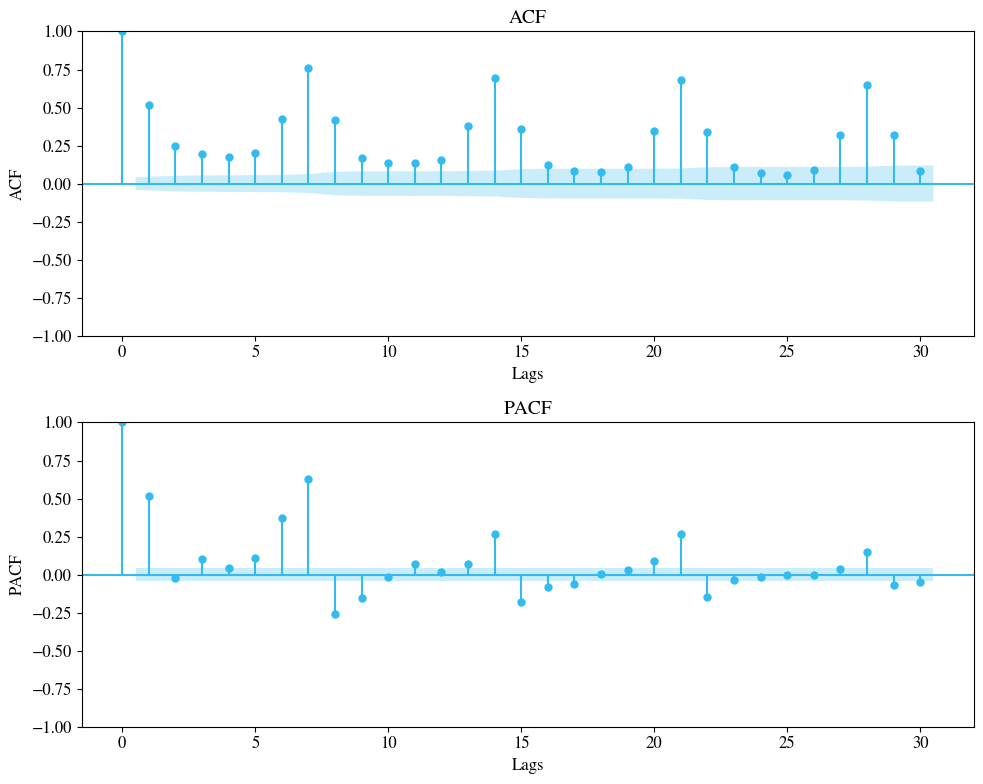

In [14]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF
plot_acf(bike_past['bike_count'], lags=30, ax=axes[0])
axes[0].set_title("ACF", fontsize=14)
axes[0].set_xlabel("Lags", fontsize=12)
axes[0].set_ylabel("ACF", fontsize=12)

# Plot PACF
plot_pacf(bike_past['bike_count'], lags=30, ax=axes[1], method='ywm')
axes[1].set_title("PACF", fontsize=14)
axes[1].set_xlabel(r"Lags", fontsize=12)
axes[1].set_ylabel("PACF", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

C:\Users\simon\AppData\Local\Temp\ipykernel_5308\3217176785.py:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


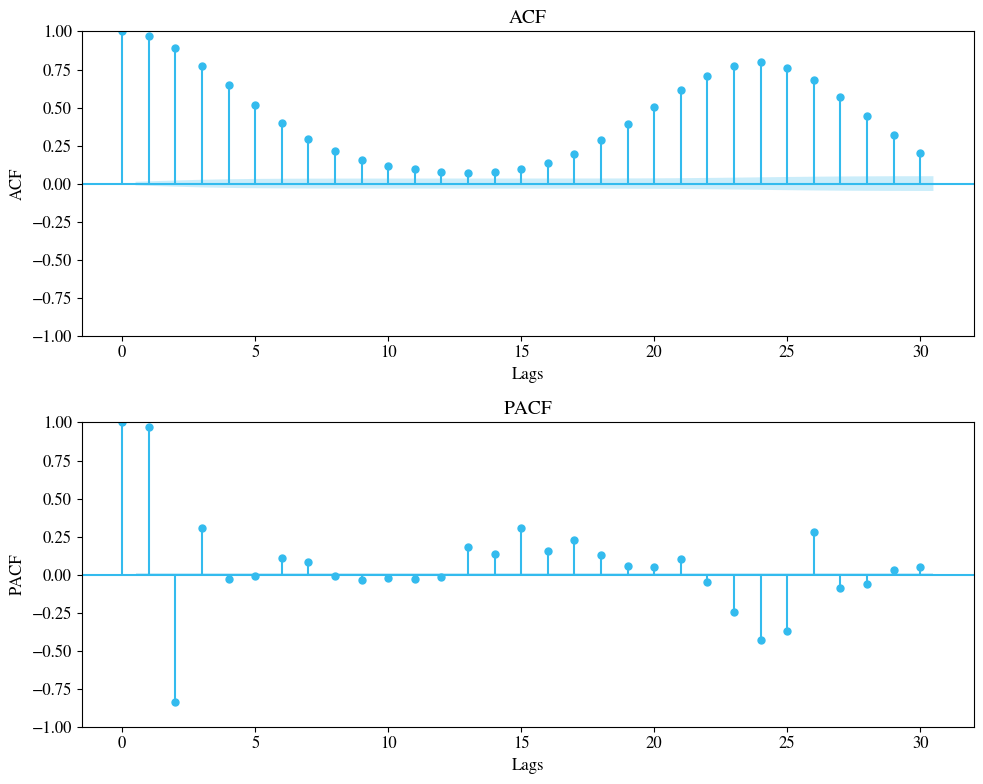

In [15]:
fig, axes = plt.subplots(2, 1, figsize=(10, 8))

# Plot ACF
plot_acf(energy_past.dropna(subset=['consumption'])['consumption'], lags=30, ax=axes[0])
axes[0].set_title("ACF", fontsize=14)
axes[0].set_xlabel("Lags", fontsize=12)
axes[0].set_ylabel("ACF", fontsize=12)

# Plot PACF
plot_pacf(energy_past.dropna(subset=['consumption'])['consumption'], lags=30, ax=axes[1], method='ywm')
axes[1].set_title("PACF", fontsize=14)
axes[1].set_xlabel(r"Lags", fontsize=12)
axes[1].set_ylabel("PACF", fontsize=12)

# Adjust layout
plt.tight_layout()
plt.show()

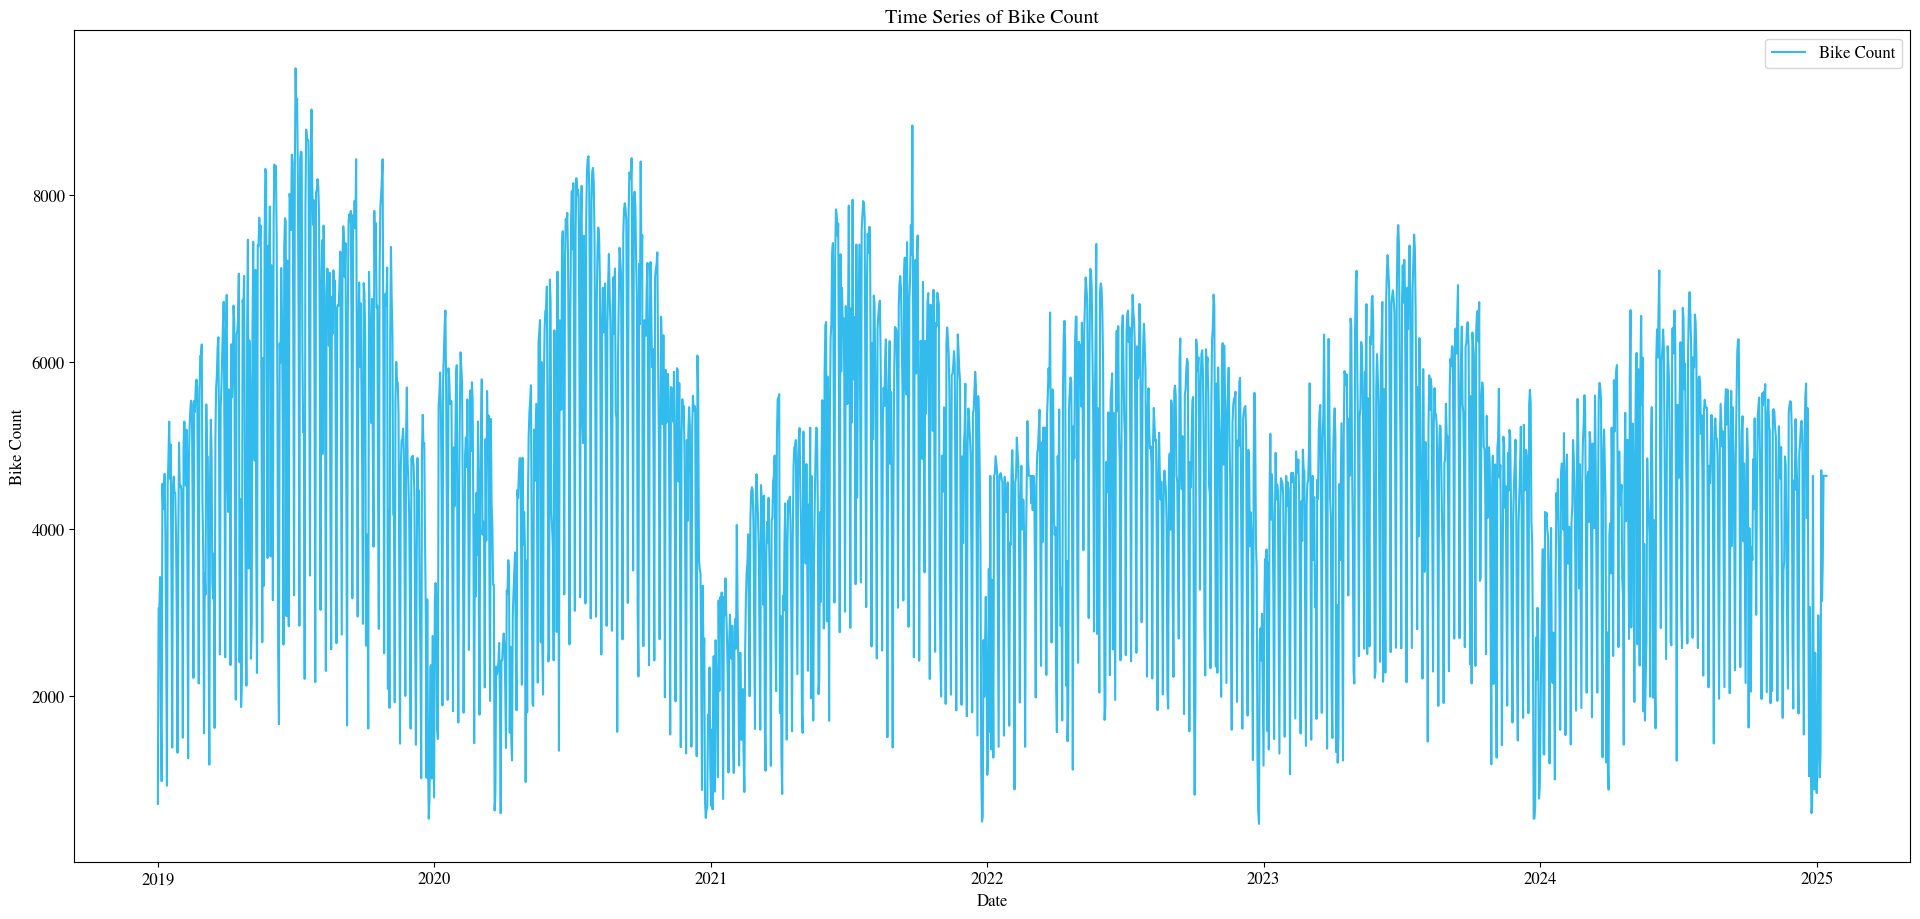

In [16]:
# Plot the time series data
plt.figure(figsize=(20, 10))
plt.plot(bike_past.index, bike_past['bike_count'], label='Bike Count')
plt.xlabel('Date')
plt.ylabel('Bike Count')
plt.title('Time Series of Bike Count')
plt.legend()
plt.show()

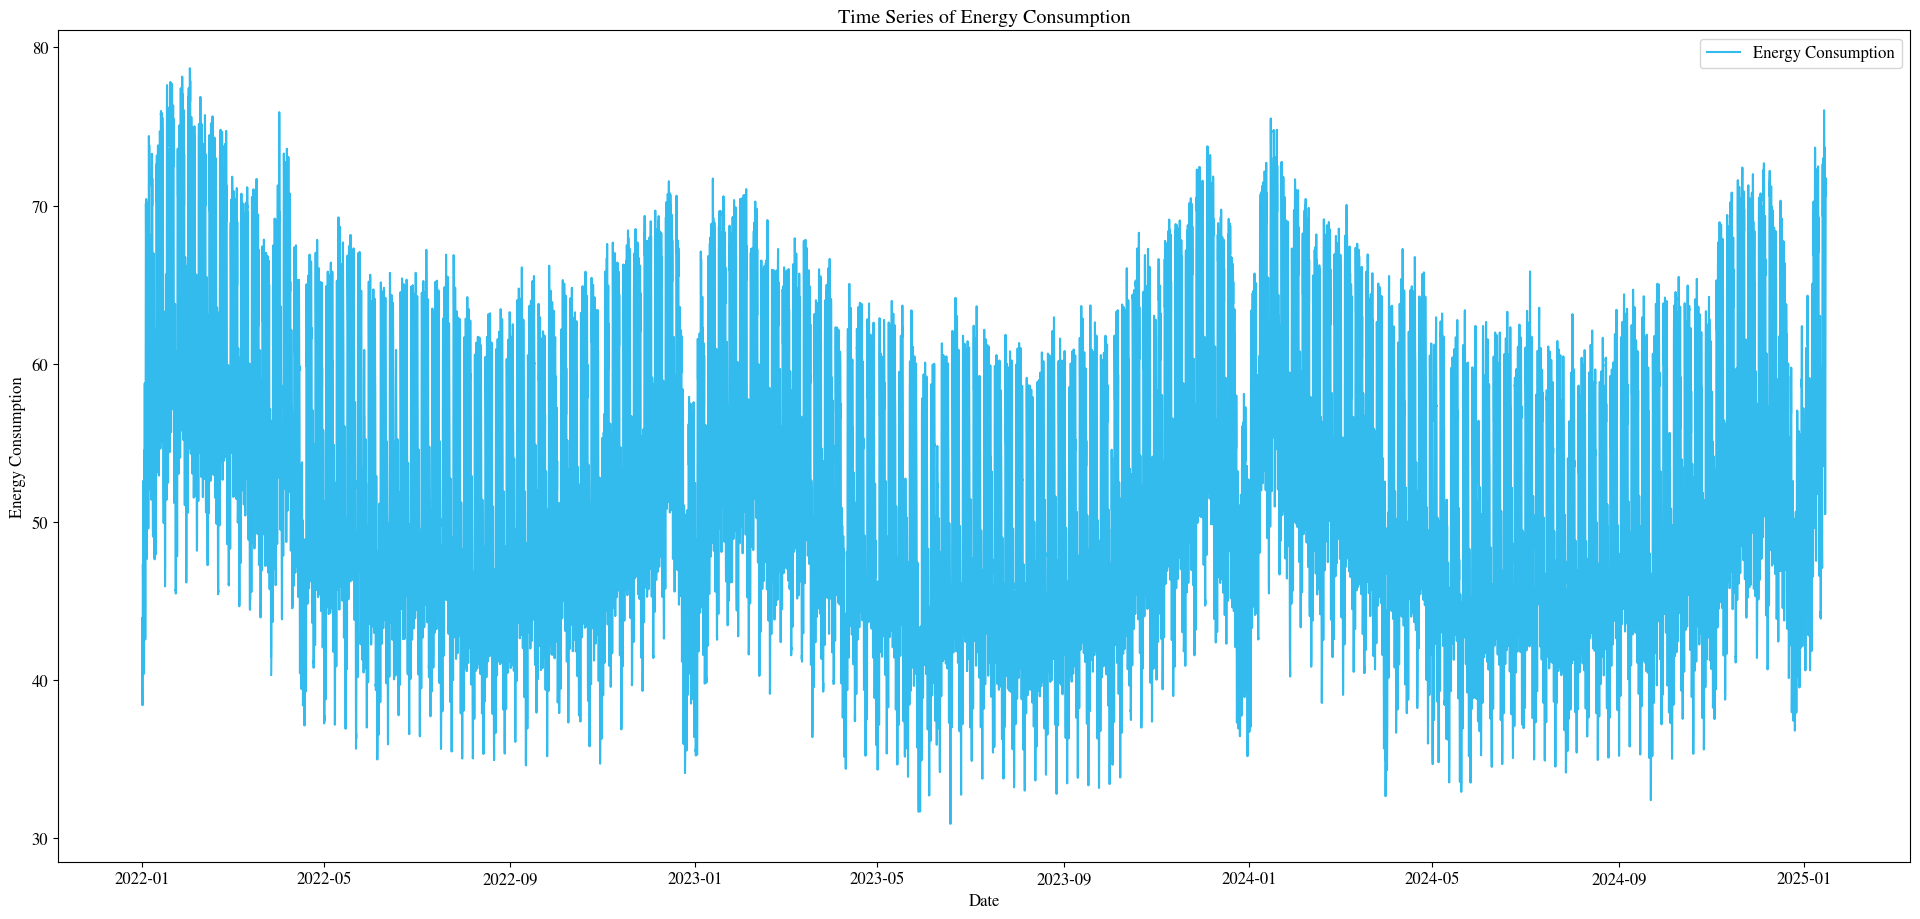

In [17]:
# Plot the time series data
plt.figure(figsize=(20, 10))
plt.plot(energy_past.index, energy_past['consumption'], label='Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption')
plt.title('Time Series of Energy Consumption')
plt.legend()
plt.show()

In [32]:
# Split data into train-val-test
# ==============================================================================
data = energy_past.loc['2012-01-01 00:00:00':'2014-12-30 23:00:00', :].copy()
end_train = '2013-12-31 23:59:00'
end_validation = '2014-11-30 23:59:00'
data_train = data.loc[: end_train, :].copy()
data_val   = data.loc[end_train:end_validation, :].copy()
data_test  = data.loc[end_validation:, :].copy()

print(f"Train dates      : {data_train.index.min()} --- {data_train.index.max()}  (n={len(data_train)})")
print(f"Validation dates : {data_val.index.min()} --- {data_val.index.max()}  (n={len(data_val)})")
print(f"Test dates       : {data_test.index.min()} --- {data_test.index.max()}  (n={len(data_test)})")

# Interactive plot of time series
# ==============================================================================
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_train.index, y=data_train['consumption'], mode='lines', name='Train'))
fig.add_trace(go.Scatter(x=data_val.index, y=data_val['consumption'], mode='lines', name='Validation'))
fig.add_trace(go.Scatter(x=data_test.index, y=data_test['consumption'], mode='lines', name='Test'))
fig.update_layout(
    title  = 'Hourly energy demand',
    xaxis_title="Time",
    yaxis_title="consumption",
    legend_title="Partition:",
    width=750,
    height=370,
    margin=dict(l=20, r=20, t=35, b=20),
    legend=dict(orientation="h", yanchor="top", y=1, xanchor="left", x=0.001)
)
#fig.update_xaxes(rangeslider_visible=True)
fig.show()

Train dates      : NaT --- NaT  (n=0)
Validation dates : NaT --- NaT  (n=0)
Test dates       : NaT --- NaT  (n=0)


<Axes: ylabel='Frequency'>

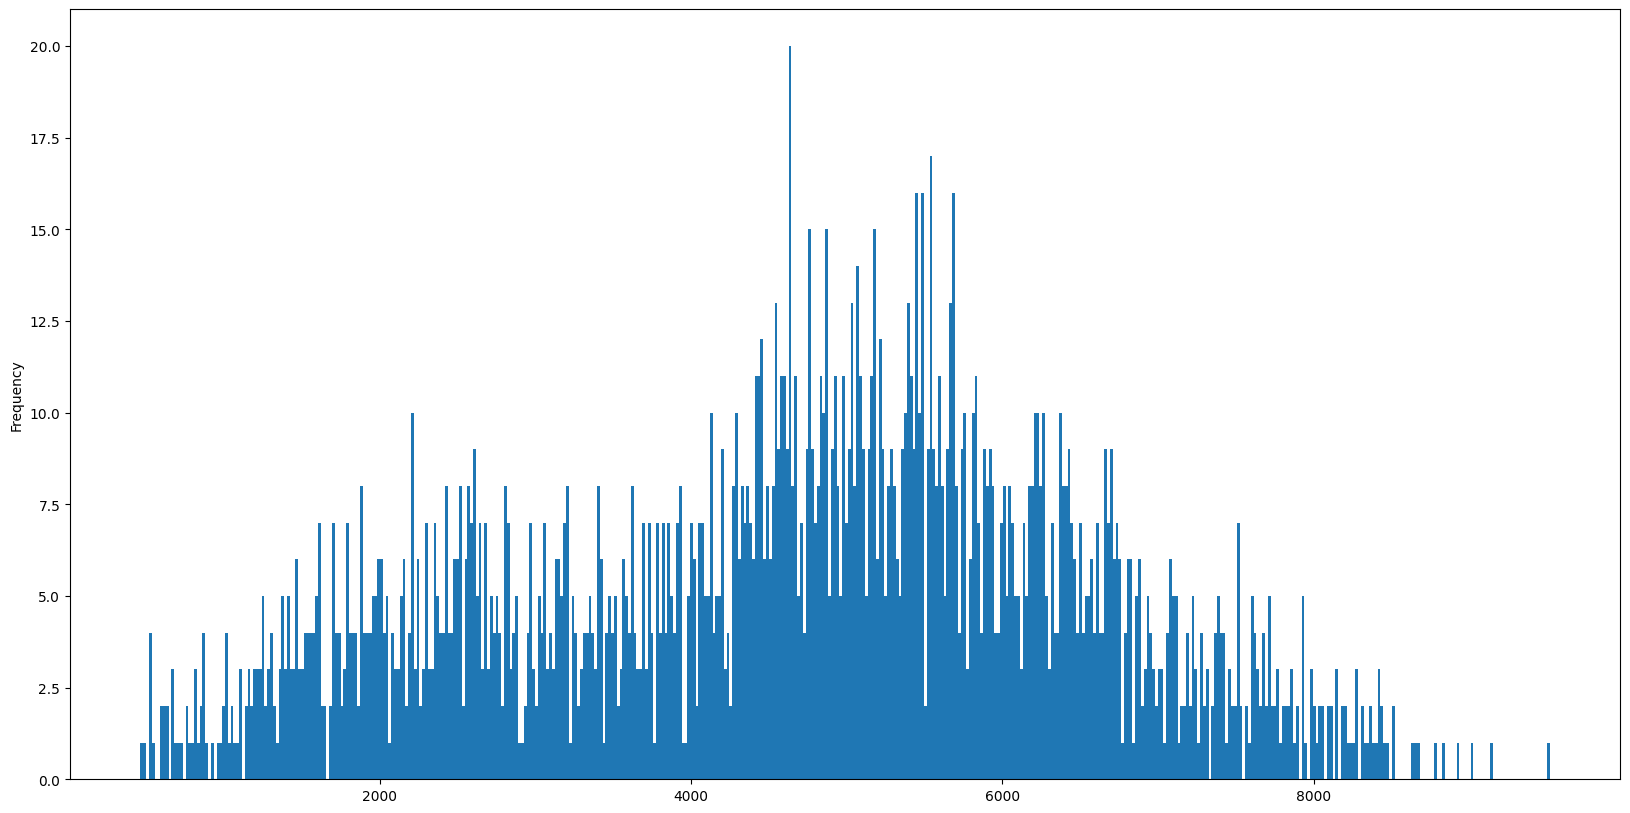

In [13]:
bike_past['bike_count'].plot(kind='hist', bins=500, figsize=(20, 10))

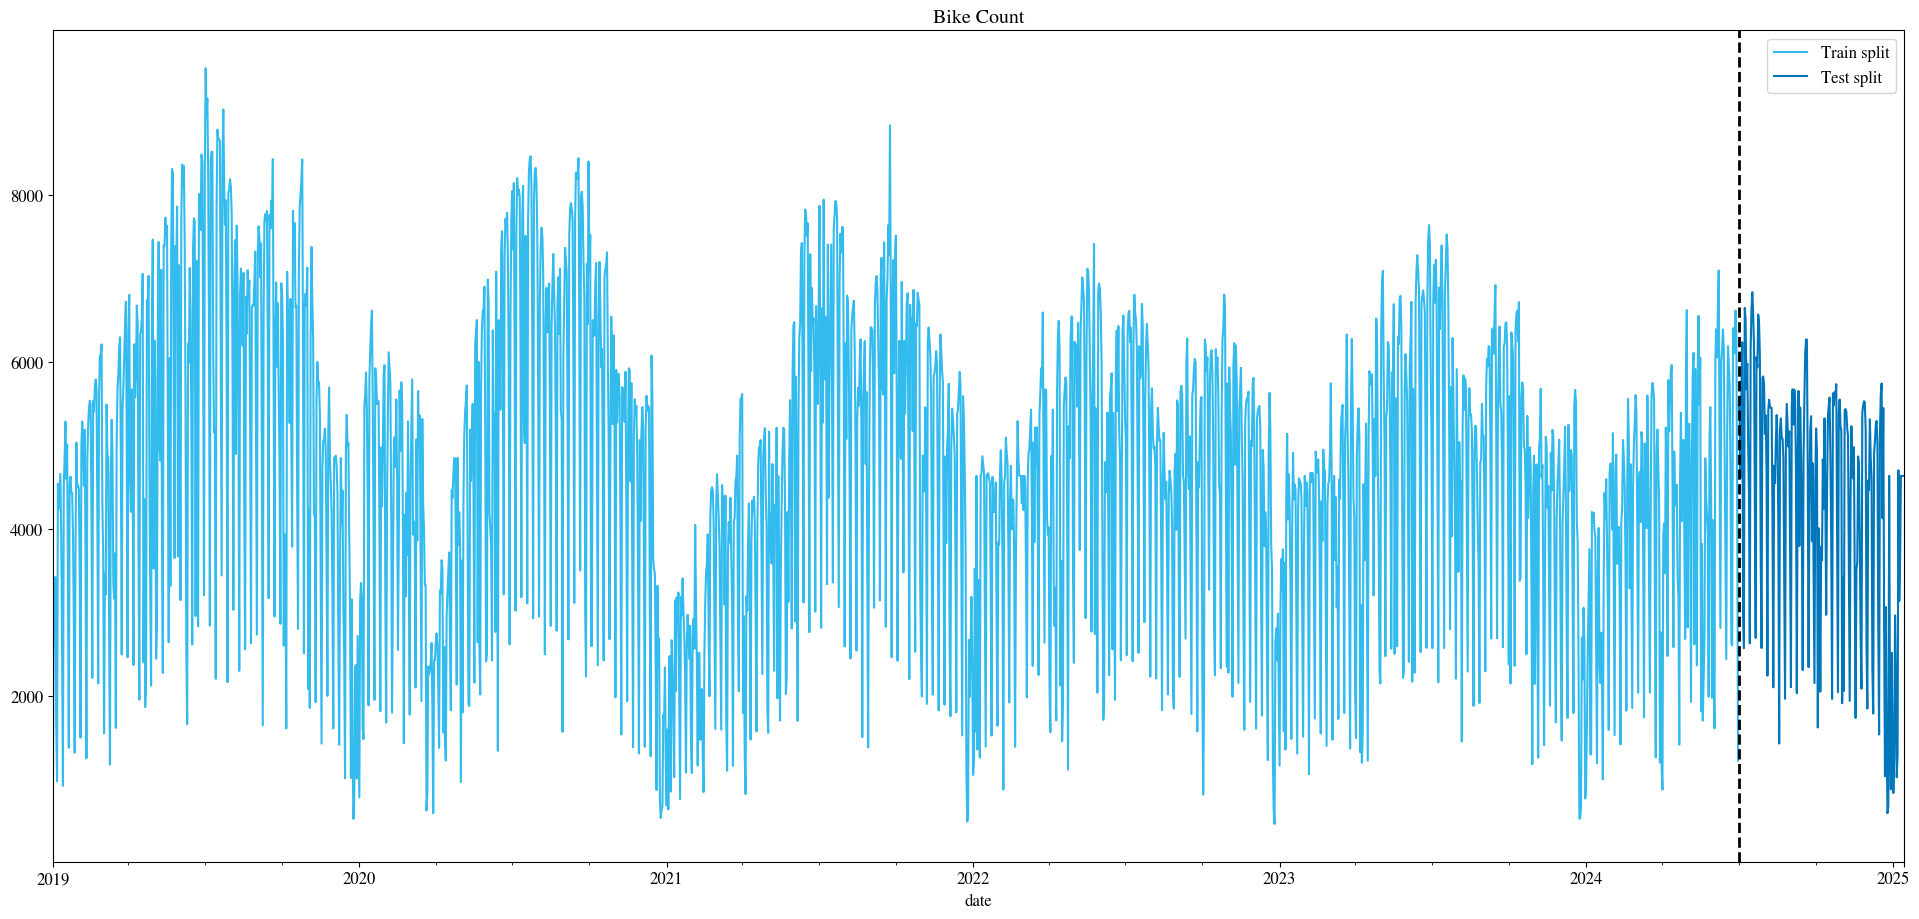

In [18]:
data_split = bike_past[['bike_count']]
train = data_split.loc[bike_past.index < '07-01-2024']
test = data_split.loc[bike_past.index >= '07-01-2024']

fig, ax = plt.subplots(figsize=(20,10))
train.plot(ax=ax, label='Train split', title='Bike Count')
test.plot(ax=ax, label='Test split')
ax.axvline('07-01-2024', color='black', linestyle='--', lw=2)
plt.legend(['Train split', 'Test split'])

<Axes: title={'center': 'Month of data'}, xlabel='date'>

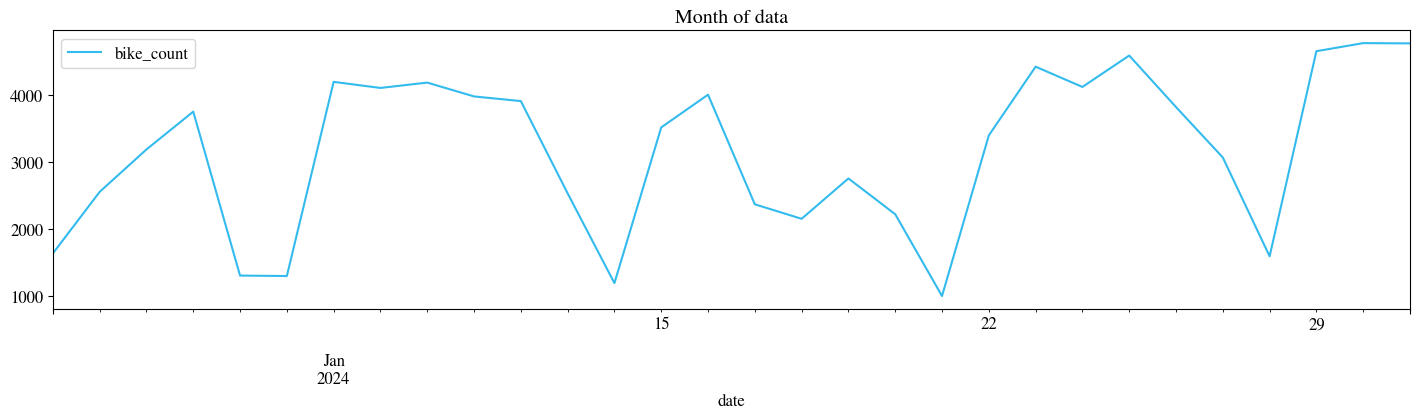

In [19]:
data_split.loc[(bike_past.index > '01-01-2024') & (bike_past.index < '02-01-2024')].plot(figsize=(15,5), title="Month of data")

<Axes: title={'center': 'Week of data'}, xlabel='date'>

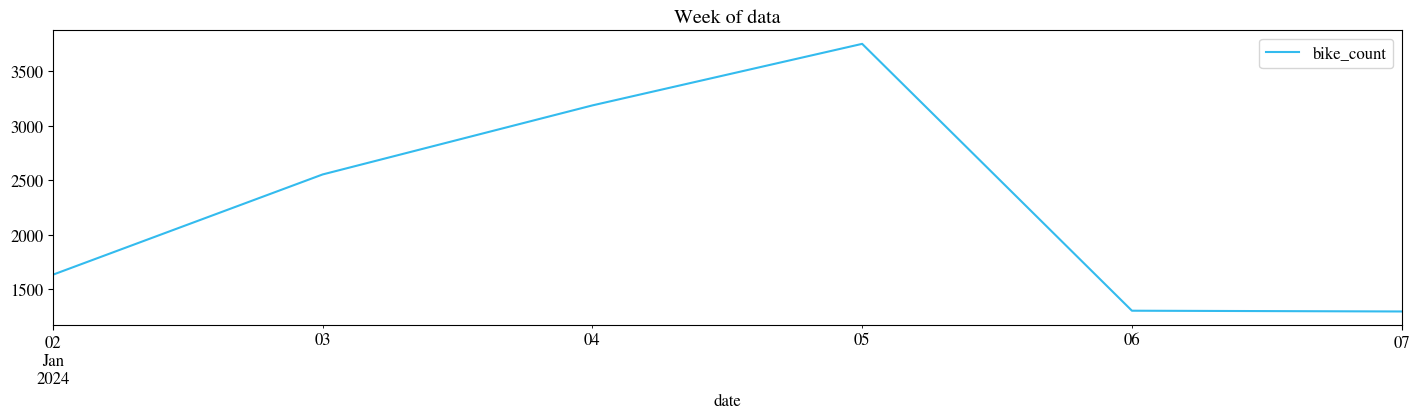

In [20]:
data_split.loc[(bike_past.index > '01-01-2024') & (bike_past.index < '01-08-2024')].plot(figsize=(15,5), title="Week of data")


In [34]:
bike_past.columns

Index(['bike_count', 'temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'rain', 'snowfall',
       'snow_depth', 'pressure_msl', 'surface_pressure', 'cloud_cover',
       'cloud_cover_low', 'cloud_cover_mid', 'cloud_cover_high',
       'et0_fao_evapotranspiration', 'vapour_pressure_deficit',
       'wind_speed_10m', 'wind_speed_100m', 'wind_direction_10m',
       'wind_direction_100m', 'wind_gusts_10m', 'soil_temperature_0_to_7cm',
       'soil_moisture_0_to_7cm', 'wet_bulb_temperature_2m',
       'sunshine_duration', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'direct_normal_irradiance',
       'global_tilted_irradiance', 'terrestrial_radiation',
       'shortwave_radiation_instant', 'direct_radiation_instant',
       'diffuse_radiation_instant', 'direct_normal_irradiance_instant',
       'global_tilted_irradiance_instant', 'terrestrial_radiation_instant',
       'month', 'day', 'quarter', 'weekday', 'la

In [49]:
datapreparer = DataPreparing()
bike_features = datapreparer.create_features_iterative(bike_past, 'bike_count')
energy_features = datapreparer.create_features_iterative(energy_past, 'consumption')

Text(0, 0.5, 'Bike Count')

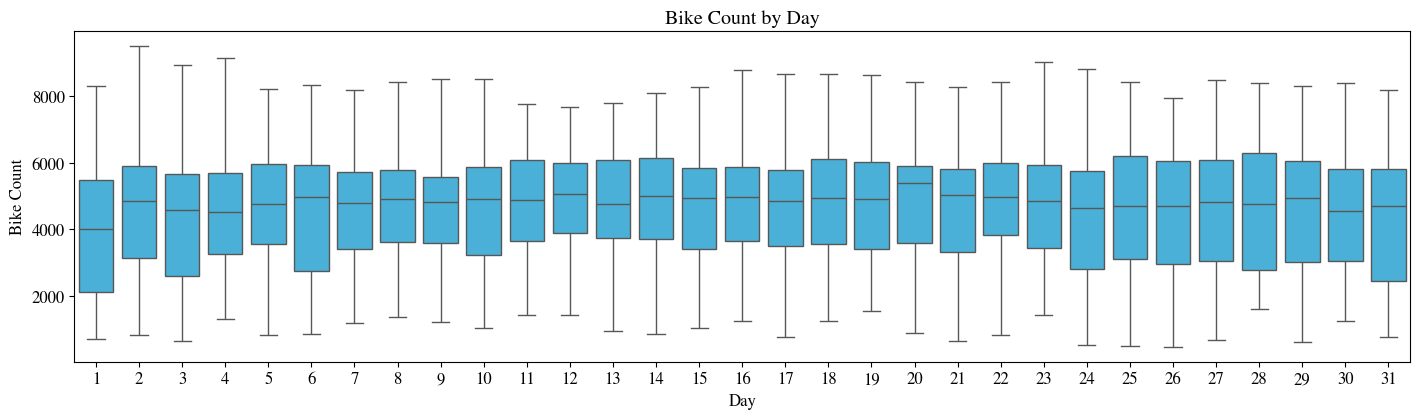

In [43]:
# Change the figsize of the plot
plt.figure(figsize=(15, 5))
sns.boxplot(data = bike_features, x = 'day', y = 'bike_count')
plt.title('Bike Count by Day')
plt.xlabel('Day')
plt.ylabel('Bike Count')

Text(0, 0.5, 'Bike Count')

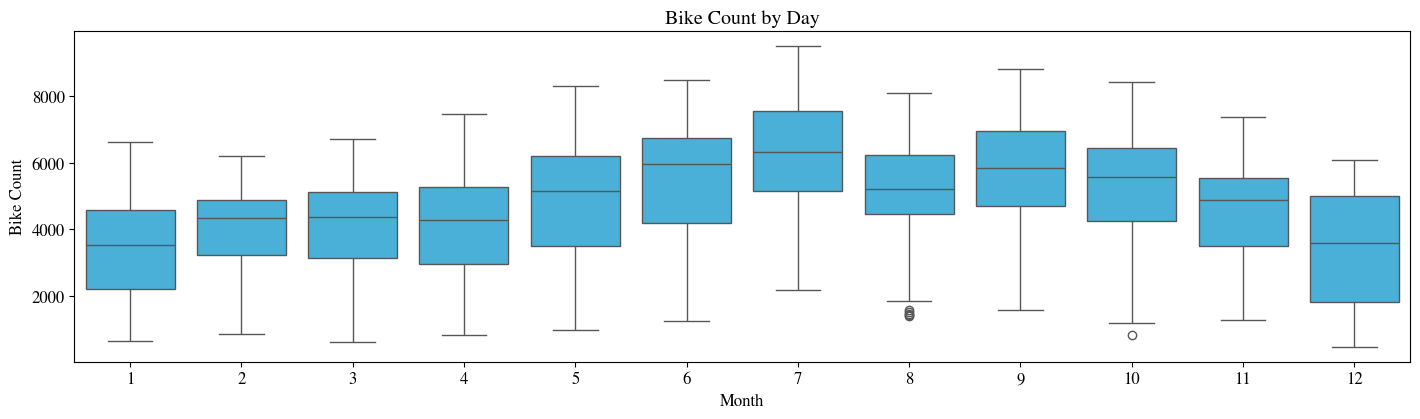

In [ ]:
# Change the figsize of the plot
plt.figure(figsize=(15, 5))
sns.boxplot(data = bike_features, x = 'month', y = 'bike_count')
plt.title('Bike Count by Month')
plt.xlabel('Month')
plt.ylabel('Bike Count')

Text(0, 0.5, 'Bike Count')

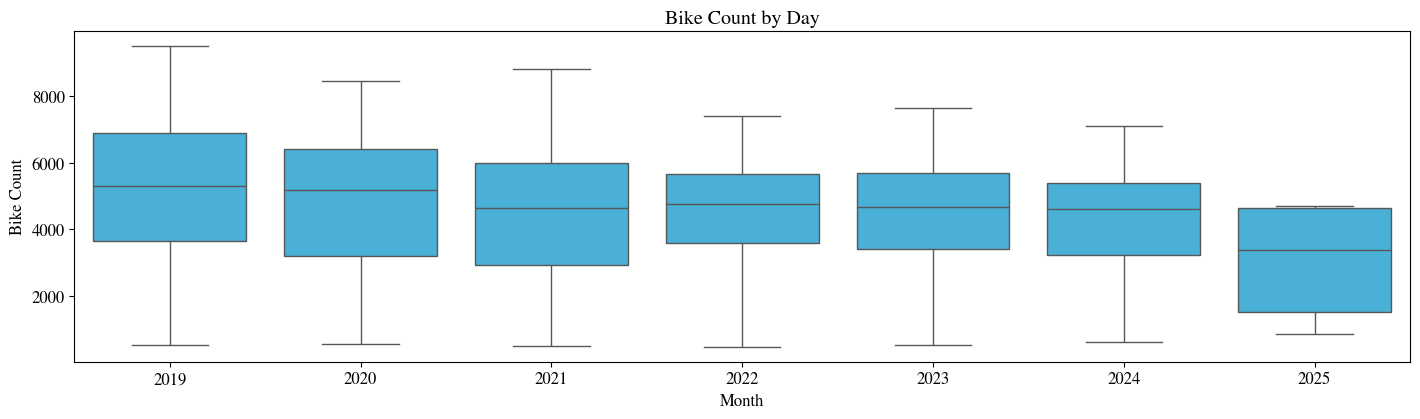

In [46]:
# Change the figsize of the plot
plt.figure(figsize=(15, 5))
sns.boxplot(data = bike_features, x = 'year', y = 'bike_count')
plt.title('Bike Count by Year')
plt.xlabel('Month')
plt.ylabel('Bike Count')

Text(0, 0.5, 'Bike Count')

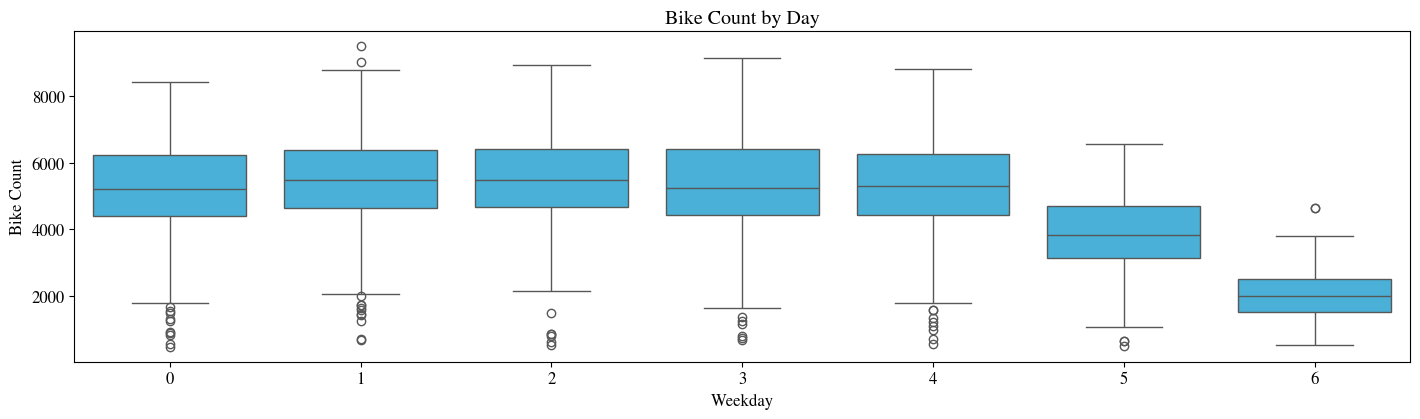

In [ ]:
# Change the figsize of the plot
plt.figure(figsize=(15, 5))
sns.boxplot(data = bike_features, x = 'weekday', y = 'bike_count')
plt.title('Bike Count by Weekday')
plt.xlabel('Weekday')
plt.ylabel('Bike Count')

In [51]:
energy_features

consumption  temperature_2m  relative_humidity_2m  \
2022-01-01 01:00:00+00:00     43.91550        9.648633             91.910058   
2022-01-01 02:00:00+00:00     41.53575        9.448633             92.279187   
2022-01-01 03:00:00+00:00     40.48075        9.275300             92.398364   
2022-01-01 04:00:00+00:00     39.56400        9.191967             92.252382   
2022-01-01 05:00:00+00:00     39.33825        8.958633             92.862136   
...                                ...             ...                   ...   
2025-01-15 10:00:00+00:00     70.70800        2.610267             96.866667   
2025-01-15 11:00:00+00:00     71.45275        2.870267             96.666667   
2025-01-15 12:00:00+00:00     71.73900        3.100267             96.133333   
2025-01-15 13:00:00+00:00     71.31125        3.236933             96.000000   
2025-01-15 14:00:00+00:00     70.63300        3.196933             96.466667   

                           dew_point_2m  apparent_temperature  precipitation  \
2022-01-01 01:00:00+00:00      8.378633              6.283385       0.093333   
2022-01-01 02:00:00+00:00      8.241967              6.052829       0.106667   
2022-01-01 03:00:00+00:00      8.091967              5.877336       0.053333   
2022-01-01 04:00:00+00:00      7.975300              5.845326       0.026667   
2022-01-01 05:00:00+00:00      7.838634              5.674294       0.013333   
...                                 ...                   ...            ...   
2025-01-15 10:00:00+00:00      2.153753             -0.506819       0.013333   
2025-01-15 11:00:00+00:00      2.382610             -0.238193       0.020000   
2025-01-15 12:00:00+00:00      2.533741              0.148549       0.000000   
2025-01-15 13:00:00+00:00      2.651434              0.395168       0.000000   
2025-01-15 14:00:00+00:00      2.681935              0.339954       0.000000   

                               rain  snowfall  snow_depth  pressure_msl  ...  \
2022-01-01 01:00:00+00:00  0.093333       0.0    0.000000   1020.960000  ...   
2022-01-01 02:00:00+00:00  0.106667       0.0    0.000000   1021.406667  ...   
2022-01-01 03:00:00+00:00  0.053333       0.0    0.000000   1021.693333  ...   
2022-01-01 04:00:00+00:00  0.026667       0.0    0.000000   1021.966667  ...   
2022-01-01 05:00:00+00:00  0.013333       0.0    0.000000   1022.226667  ...   
...                             ...       ...         ...           ...  ...   
2025-01-15 10:00:00+00:00  0.000000       0.0    0.052667   1031.646667  ...   
2025-01-15 11:00:00+00:00  0.000000       0.0    0.052000   1031.773333  ...   
2025-01-15 12:00:00+00:00  0.000000       0.0    0.052000   1031.833333  ...   
2025-01-15 13:00:00+00:00  0.000000       0.0    0.051333   1032.140000  ...   
2025-01-15 14:00:00+00:00  0.000000       0.0    0.051333   1032.446667  ...   

                           diff_lag_2  diff_lag_3  diff_lag_4  is_holiday  \
2022-01-01 01:00:00+00:00         NaN         NaN         NaN           1   
2022-01-01 02:00:00+00:00         NaN         NaN         NaN           1   
2022-01-01 03:00:00+00:00         NaN         NaN         NaN           1   
2022-01-01 04:00:00+00:00    -3.43475         NaN         NaN           1   
2022-01-01 05:00:00+00:00    -1.97175    -4.35150         NaN           1   
...                               ...         ...         ...         ...   
2025-01-15 10:00:00+00:00     8.47650    15.68975    19.38850           0   
2025-01-15 11:00:00+00:00     3.09075     8.50775    15.72100           0   
2025-01-15 12:00:00+00:00     0.77600     3.83550     9.25250           0   
2025-01-15 13:00:00+00:00     1.03100     1.06225     4.12175           0   
2025-01-15 14:00:00+00:00    -0.14150     0.60325     0.63450           0   

                           corona_phase  rolling_mean_7  rolling_mean_30  \
2022-01-01 01:00:00+00:00           3.0             NaN              NaN   
2022-01-01 02:00:00+00:00           3.0             NaN            

ValueError: cannot reindex on an axis with duplicate labels

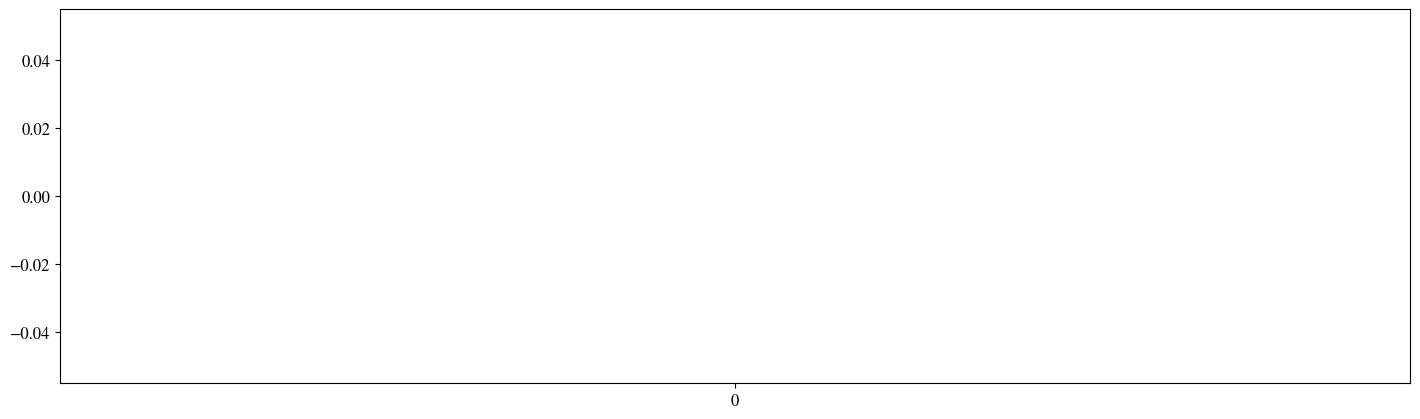

In [52]:
# Change the figsize of the plot
plt.figure(figsize=(15, 5))
sns.boxplot(data = energy_features, x = 'weekday', y = 'consumption')
plt.title('Energy demand')
plt.xlabel('Hour')
plt.ylabel('Energy demand')

C:\Users\simon\AppData\Local\Temp\ipykernel_5308\2007827634.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


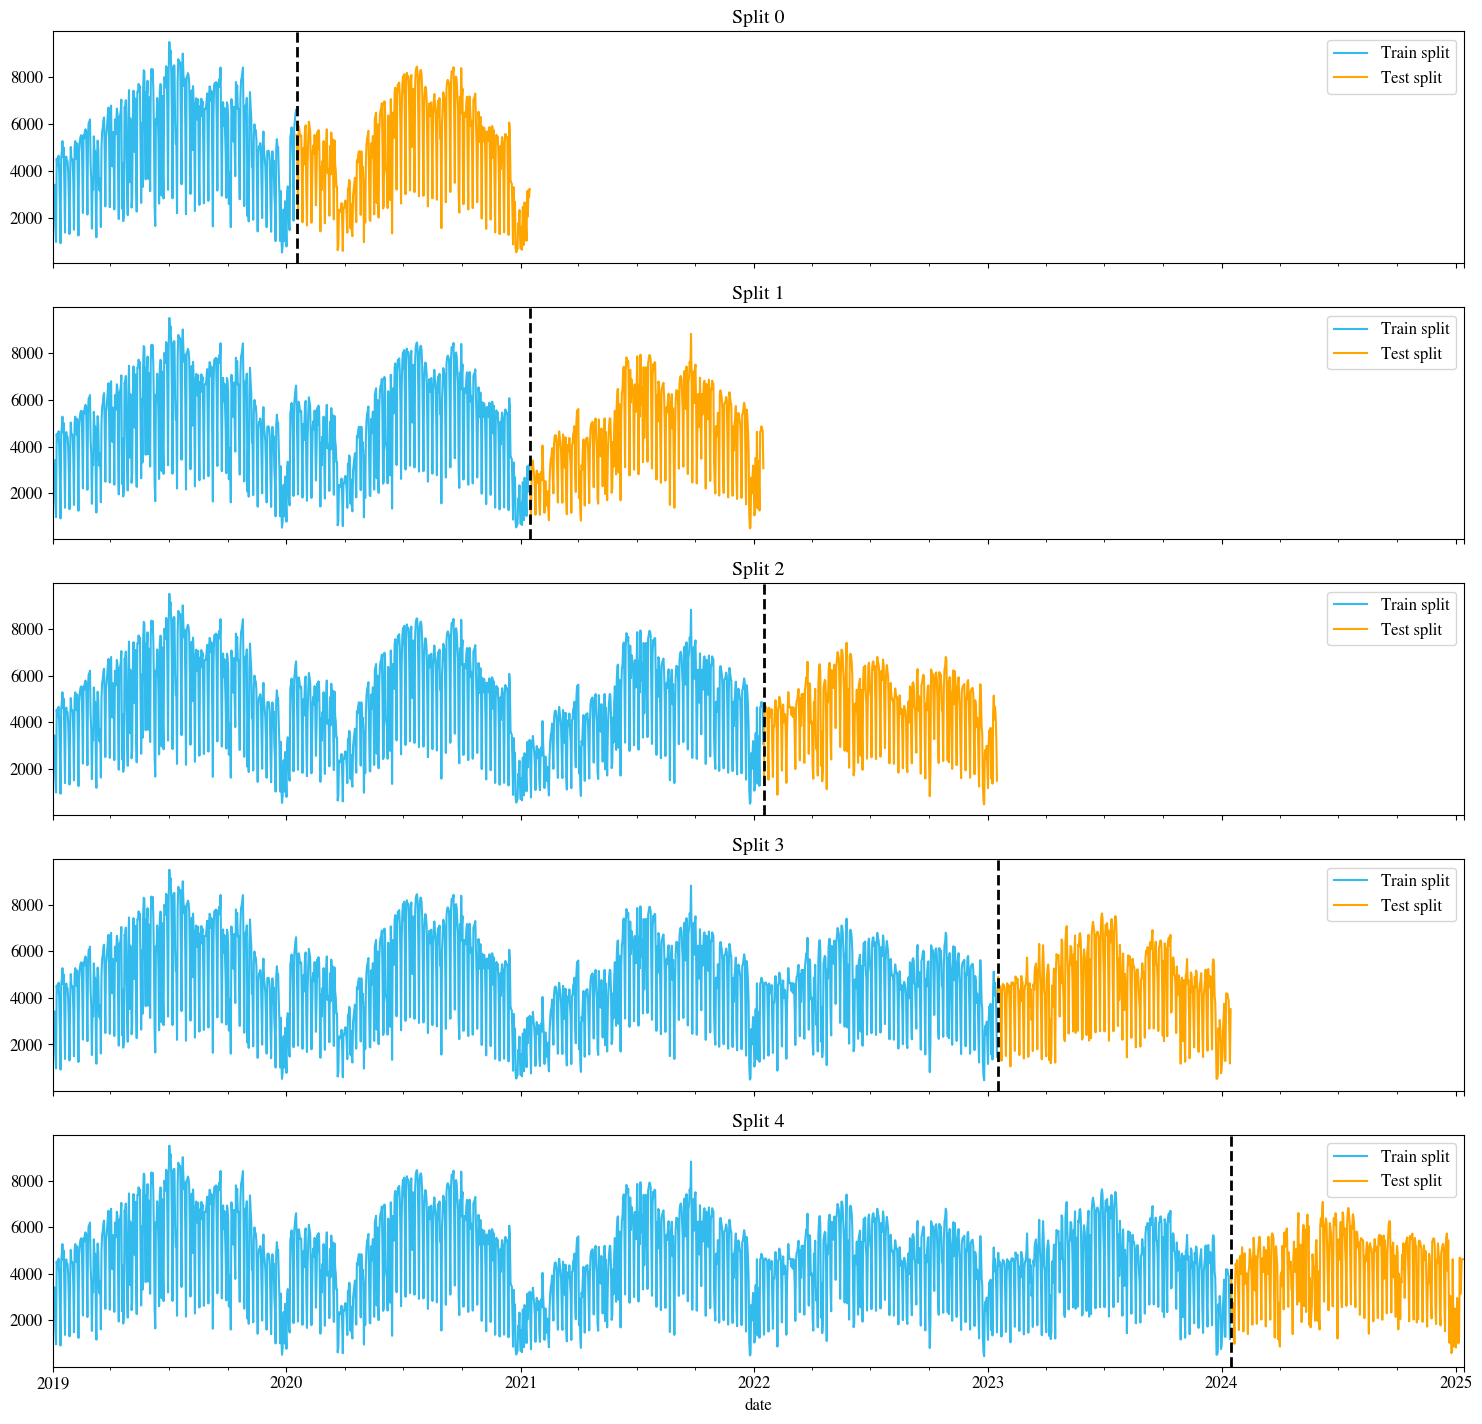

In [ ]:
data_split = bike_past[['bike_count']]

tss = TimeSeriesSplit(n_splits=5, test_size=365, gap = 0) # 1 year

fig, axs = plt.subplots(5,1, figsize=(15,15),sharex=True)

fold = 0
for train_index, test_index in tss.split(data_split):
    train = data_split.iloc[train_index]
    test = data_split.iloc[test_index]
    train.plot(ax=axs[fold], label='Train split', title=f'Split {fold}')
    test.plot(ax=axs[fold], label='Test split', color='orange')
    axs[fold].axvline(test.index[0], color='black', linestyle='--', lw=2)
    axs[fold].legend(['Train split', 'Test split'])
    fold += 1
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  


C:\Users\simon\AppData\Local\Temp\ipykernel_5308\439991013.py:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout(rect=[0, 0, 1, 0.96])


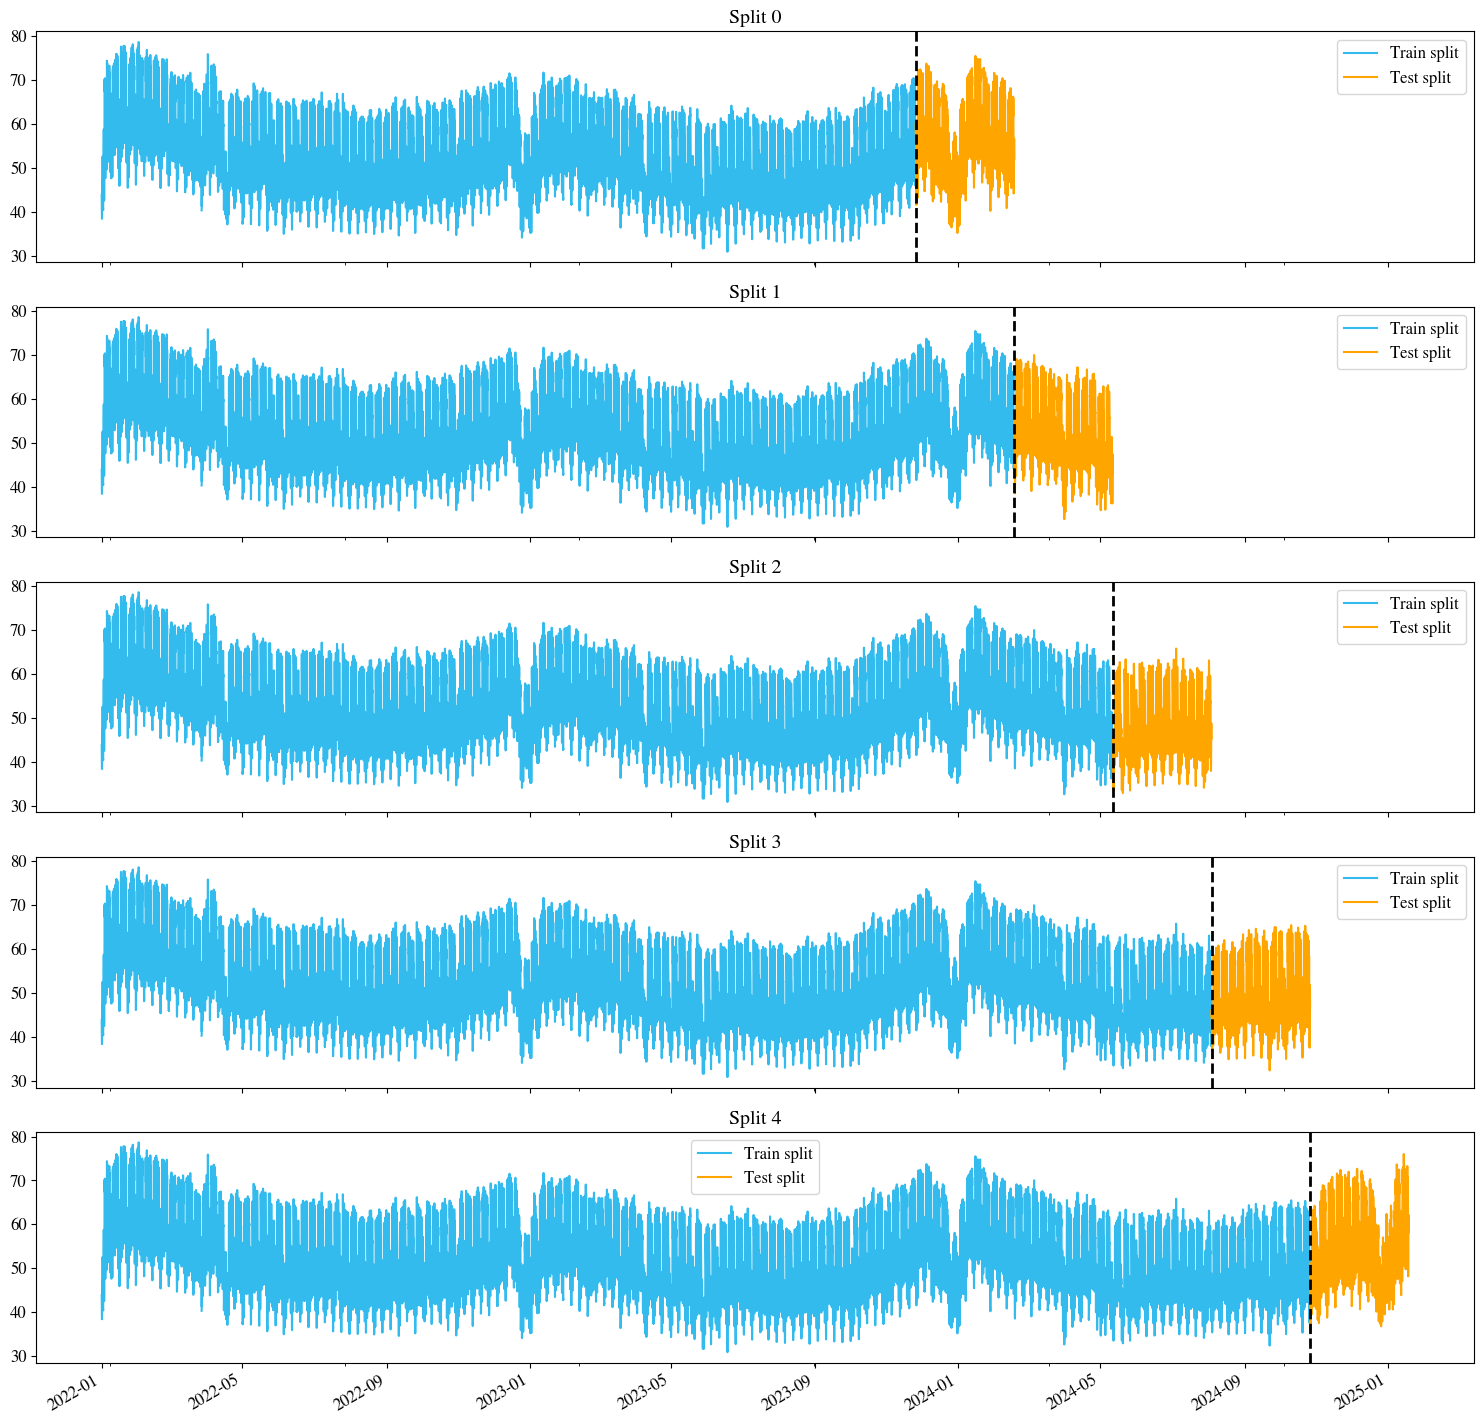

In [66]:
energy_split = energy_past[['consumption']]

tss = TimeSeriesSplit(n_splits=5, test_size=24*7*12, gap = 0) # 10 weeks

fig, axs = plt.subplots(5,1, figsize=(15,15),sharex=True)

fold = 0
for train_index, test_index in tss.split(energy_split):
    train = energy_split.iloc[train_index]
    test = energy_split.iloc[test_index]
    train.plot(ax=axs[fold], label='Train split', title=f'Split {fold}')
    test.plot(ax=axs[fold], label='Test split', color='orange')
    axs[fold].axvline(test.index[0], color='black', linestyle='--', lw=2)
    axs[fold].legend(['Train split', 'Test split'])
    fold += 1
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  


# energy_split = energy_past[['consumption']]
# tss = TimeSeriesSplit(n_splits=5, test_size=168*10, gap = 0) # 10 weeks

# fig, axs = plt.subplots(5,1, figsize=(15,15),sharex=True)

# fold = 0
# for train_index, test_index in tss.split(energy_split):
#     train = energy_split.iloc[train_index]
#     test = energy_split.iloc[test_index]
#     train.plot(ax=axs[fold], label=f'Train split {fold}', title='Energy demand')
#     test.plot(ax=axs[fold], label=f'Test split {fold}')
#     fold += 1
    
# plt.tight_layout(rect=[0, 0, 1, 0.96])  
# plt.legend(['Train split', 'Test split'])

In [ ]:
tss = ExpandingSlidingWindowSplitter(n_splits=10, fh=7, gap = 0)

fig, axs = plt.subplots(10,1, figsize=(15,15),sharex=True)

fold = 0
for train_index, test_index in tss.split(data_split):
    train = data_split.iloc[train_index]
    test = data_split.iloc[test_index]
    train.plot(ax=axs[fold], label=f'Train split {fold}', title='Bike Count')
    test.plot(ax=axs[fold], label=f'Test split {fold}')
    fold += 1
    
plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.legend(['Train split', 'Test split'])